In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
# Load the dataset
data = pd.read_csv('./data/berlin-houses.csv')

# Inspect the data
print("Dataset Dimensions - Rows, Columns:", data.shape)
print("Column Names:", data.columns)
print("First Few Rows:")
data.head()
print("Missing Values:", data.isnull().sum())

Dataset Dimensions - Rows, Columns: (1038, 27)
Column Names: Index(['id', 'lat', 'lon', 'cold_price', 'currency', 'short_listed',
       'postcode_id', 'balcony', 'builtin_kitchen', 'created_date',
       'energy_certificate', 'has_new_flag', 'living_space',
       'new_home_builder', 'number_rooms', 'private_offer', 'modified_date',
       'published_date', 'warm_price', 'address', 'link', 'quarter', 'garden',
       'listing_type', 'localhost_date', 'no_longer_available',
       'no_longer_available_date'],
      dtype='object')
First Few Rows:
Missing Values: id                            0
lat                           0
lon                           0
cold_price                    0
currency                      0
short_listed                  0
postcode_id                   0
balcony                       0
builtin_kitchen               0
created_date                 37
energy_certificate            0
has_new_flag                  0
living_space                 20
new_home_builde

In [15]:
# Drop rows with missing values in crucial columns
data = data.dropna(subset=['cold_price', 'warm_price', 'living_space', 'lat', 'lon', 'postcode_id', 'created_date'])

# Ensure 'cold_price' and 'living_space' are numeric for analysis
data['cold_price'] = pd.to_numeric(data['cold_price'], errors='coerce')
data['warm_price'] = pd.to_numeric(data['warm_price'], errors='coerce')
data['living_space'] = pd.to_numeric(data['living_space'], errors='coerce')

# Calculate 'price_per_meter' (price per square meter)
data['price_per_meter'] = data['cold_price'] / data['living_space']

# Convert date columns to datetime format
data['created_date'] = pd.to_datetime(data['created_date'], errors='coerce')
data['published_date'] = pd.to_datetime(data['published_date'], errors='coerce')

# Check data after preprocessing
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 1 to 1037
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1001 non-null   int64         
 1   lat                       1001 non-null   float64       
 2   lon                       1001 non-null   float64       
 3   cold_price                1001 non-null   float64       
 4   currency                  1001 non-null   object        
 5   short_listed              1001 non-null   bool          
 6   postcode_id               1001 non-null   int64         
 7   balcony                   1001 non-null   bool          
 8   builtin_kitchen           1001 non-null   bool          
 9   created_date              1001 non-null   datetime64[ns]
 10  energy_certificate        1001 non-null   bool          
 11  has_new_flag              1001 non-null   bool          
 12  living_space        

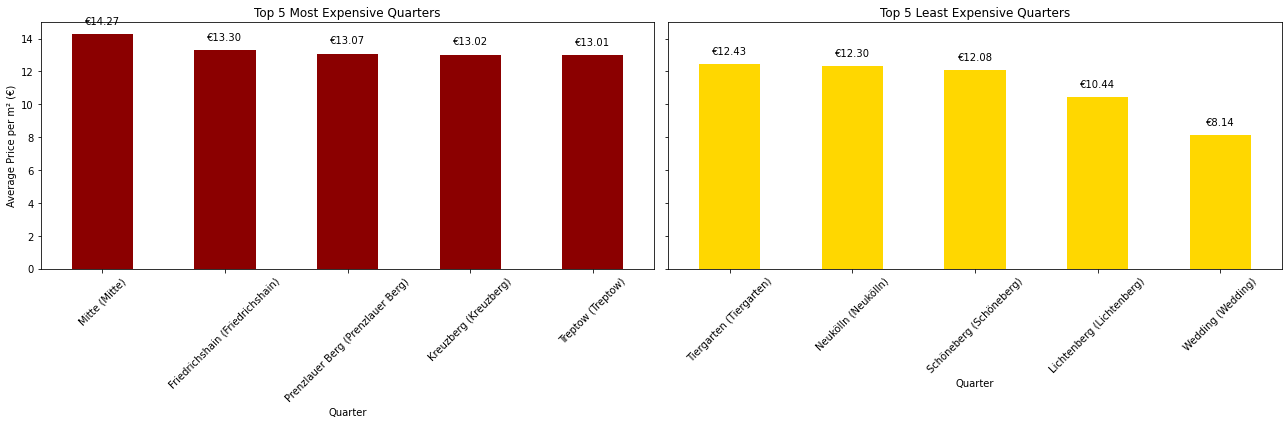

In [16]:
# Group by quarter and calculate the average price per meter for each unique quarter
avg_price_per_quarter = data.groupby('quarter')['price_per_meter'].mean().sort_values(ascending=False).reset_index()

# Plot the most and least expensive quarters
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Most Expensive Quarters
top_expensive = avg_price_per_quarter.head(5)
top_expensive.plot(kind='bar', x='quarter', y='price_per_meter', ax=ax[0], legend=False, color='darkred')
ax[0].set_title('Top 5 Most Expensive Quarters')
ax[0].set_xlabel('Quarter')
ax[0].set_ylabel('Average Price per m² (€)')
ax[0].tick_params(axis='x', rotation=45)

# Add annotations for most expensive quarters
for i, value in enumerate(top_expensive['price_per_meter']):
    ax[0].text(i, value + 0.5, f"€{value:.2f}", ha='center', va='bottom', fontsize=10)

# Least Expensive Quarters
least_expensive = avg_price_per_quarter.tail(5)
least_expensive.plot(kind='bar', x='quarter', y='price_per_meter', ax=ax[1], legend=False, color='gold')
ax[1].set_title('Top 5 Least Expensive Quarters')
ax[1].set_xlabel('Quarter')
ax[1].tick_params(axis='x', rotation=45)

# Add annotations for least expensive quarters
for i, value in enumerate(least_expensive['price_per_meter']):
    ax[1].text(i, value + 0.5, f"€{value:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

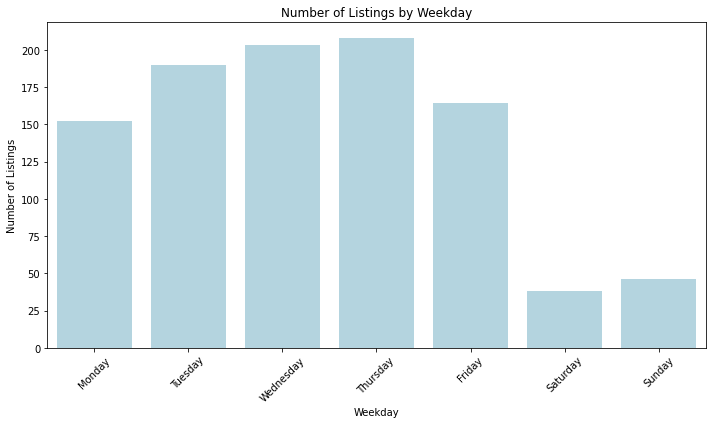

In [17]:
data['published_date'] = pd.to_datetime(data['published_date'], errors='coerce')

# Create a new column for the weekday
data['weekday'] = data['published_date'].dt.day_name()

# Plot listings by weekday
plt.figure(figsize=(10, 6))
sns.countplot(
    x='weekday', 
    data=data, 
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    color='lightblue'
)
plt.title('Number of Listings by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Group by quarter and calculate min, max, and average price per square meter
price_range_by_quarter = data.groupby('quarter')['price_per_meter'].agg(
    min_price='min',
    max_price='max',
    avg_price='mean'
).reset_index()

# Sort the table by average price in descending order for better readability
price_range_by_quarter = price_range_by_quarter.sort_values(by='avg_price', ascending=False)

# Display the table
pd.options.display.float_format = '€{:,.2f}'.format
price_range_by_quarter

,quarter,min_price,max_price,avg_price
3,Mitte (Mitte),€5.37,€25.00,€14.27
0,Friedrichshain (Friedrichshain),€0.44,€25.16,€13.30
6,Prenzlauer Berg (Prenzlauer Berg),€0.00,€23.00,€13.07
1,Kreuzberg (Kreuzberg),€5.65,€23.98,€13.02
9,Treptow (Treptow),€8.94,€21.76,€13.01
5,Plänterwald (Treptow),€12.86,€12.86,€12.86
8,Tiergarten (Tiergarten),€8.69,€20.30,€12.43
4,Neukölln (Neukölln),€6.00,€21.00,€12.30
7,Schöneberg (Schöneberg),€0.00,€20.01,€12.08
2,Lichtenberg (Lichtenberg),€5.69,€20.57,€10.44


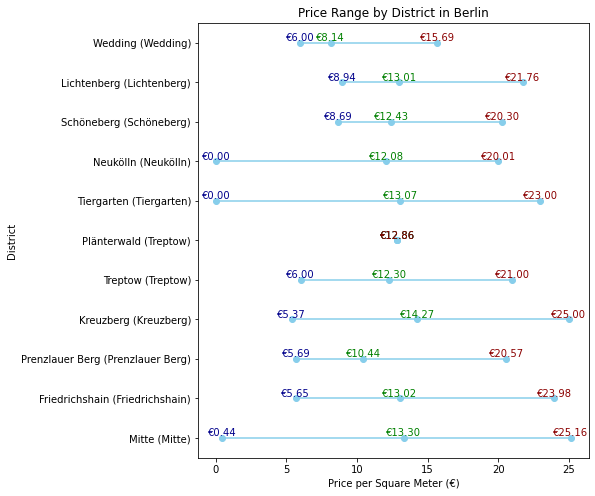

In [19]:
# Extract values for plotting
quarters = price_range_by_quarter['quarter']
min_prices = price_range_by_quarter['min_price']
max_prices = price_range_by_quarter['max_price']
avg_prices = price_range_by_quarter['avg_price']

# Plotting
plt.figure(figsize=(7, 8))

# Plot each line and dots
for i, quarter in enumerate(quarters):
    # Plot line connecting min, average, and max
    plt.plot([min_prices[i], avg_prices[i], max_prices[i]], [quarter] * 3, marker='o', color='skyblue', linestyle='-', markersize=6)

    # Annotate min, avg, and max points
    plt.text(min_prices[i], i, f"€{min_prices[i]:.2f}", ha='center', va='bottom', fontsize=10, color="darkblue")
    plt.text(avg_prices[i], i, f"€{avg_prices[i]:.2f}", ha='center', va='bottom', fontsize=10, color="green")
    plt.text(max_prices[i], i, f"€{max_prices[i]:.2f}", ha='center', va='bottom', fontsize=10, color="darkred")

# Labels and title
plt.title('Price Range by District in Berlin')
plt.xlabel('Price per Square Meter (€)')
plt.ylabel('District')
plt.show()

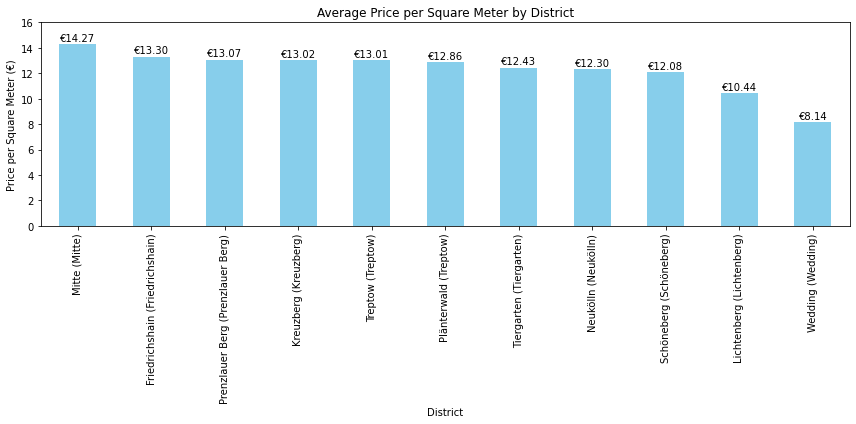

In [20]:
# Price per square meter by quarter (district) sorted in descending order
price_per_meter_by_postcode = data.groupby('quarter')['price_per_meter'].mean().sort_values(ascending=False)

# Plot price per square meter by district
plt.figure(figsize=(12, 6))
ax = price_per_meter_by_postcode.plot(kind='bar', color='skyblue')
plt.title('Average Price per Square Meter by District')
plt.xlabel('District')
plt.ylabel('Price per Square Meter (€)')

# Set the y-axis upper limit to 16
ax.set_ylim(0, 16)

# Adding annotations on top of each bar
for index, value in enumerate(price_per_meter_by_postcode):
    plt.text(index, value + 0.1, f"€{value:.2f}", ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [21]:
# Load the .geojson file
gdf = gpd.read_file("./data/berlin.geojson")

# Display the first few rows to inspect the data
gdf.head()

,plz,geometry
0,10115,"POLYGON ((13.36586 52.53566, 13.36829 52.53329..."
1,10117,"POLYGON ((13.37374 52.52780, 13.37382 52.52770..."
2,10119,"POLYGON ((13.39902 52.52701, 13.40134 52.52631..."
3,10178,"POLYGON ((13.39902 52.52701, 13.39877 52.52679..."
4,10179,"POLYGON ((13.40305 52.51217, 13.40261 52.51186..."


In [22]:
unique_postcode_quarter = data[['postcode_id', 'quarter']].drop_duplicates()
print(unique_postcode_quarter)

     postcode_id                            quarter
1          12051                Neukölln (Neukölln)
2          13355                  Wedding (Wedding)
3          10245    Friedrichshain (Friedrichshain)
4          10963              Kreuzberg (Kreuzberg)
6          12435                  Treptow (Treptow)
7          10243    Friedrichshain (Friedrichshain)
8          10117                      Mitte (Mitte)
9          10405  Prenzlauer Berg (Prenzlauer Berg)
10         10178                      Mitte (Mitte)
12         12055                Neukölln (Neukölln)
17         10969              Kreuzberg (Kreuzberg)
18         12047                Neukölln (Neukölln)
19         10249    Friedrichshain (Friedrichshain)
20         10965              Kreuzberg (Kreuzberg)
25         10317          Lichtenberg (Lichtenberg)
26         12059                Neukölln (Neukölln)
30         10961              Kreuzberg (Kreuzberg)
37         10247    Friedrichshain (Friedrichshain)
38         1

In [23]:
gdf['plz'] = gdf['plz'].astype(int)

In [24]:
unique_postcode_quarter = unique_postcode_quarter.rename(columns={'postcode_id': 'postcode_id_right'})
gdf_berlin = gdf.merge(unique_postcode_quarter, left_on='plz', right_on='postcode_id_right', how='left', suffixes=('_left', '_right'))

# Check for the 'quarter' column after merge
print("Columns after merge:", gdf_berlin.columns)
print(gdf_berlin[['plz', 'quarter']].head())

Columns after merge: Index(['plz', 'geometry', 'postcode_id_right', 'quarter'], dtype='object')
     plz                            quarter
0  10115                      Mitte (Mitte)
1  10117                      Mitte (Mitte)
2  10119                      Mitte (Mitte)
3  10119  Prenzlauer Berg (Prenzlauer Berg)
4  10178                      Mitte (Mitte)


In [25]:
# Calculate the average price per meter for each postcode_id
avg_price_per_area = data.groupby('postcode_id')['price_per_meter'].mean()

# Reset the index to make 'postcode_id' a column
avg_price_per_area = avg_price_per_area.reset_index()

# Merge the average price data with gdf_berlin
gdf_berlin = gdf_berlin.merge(avg_price_per_area[['postcode_id', 'price_per_meter']], left_on='plz', right_on='postcode_id', how='left')

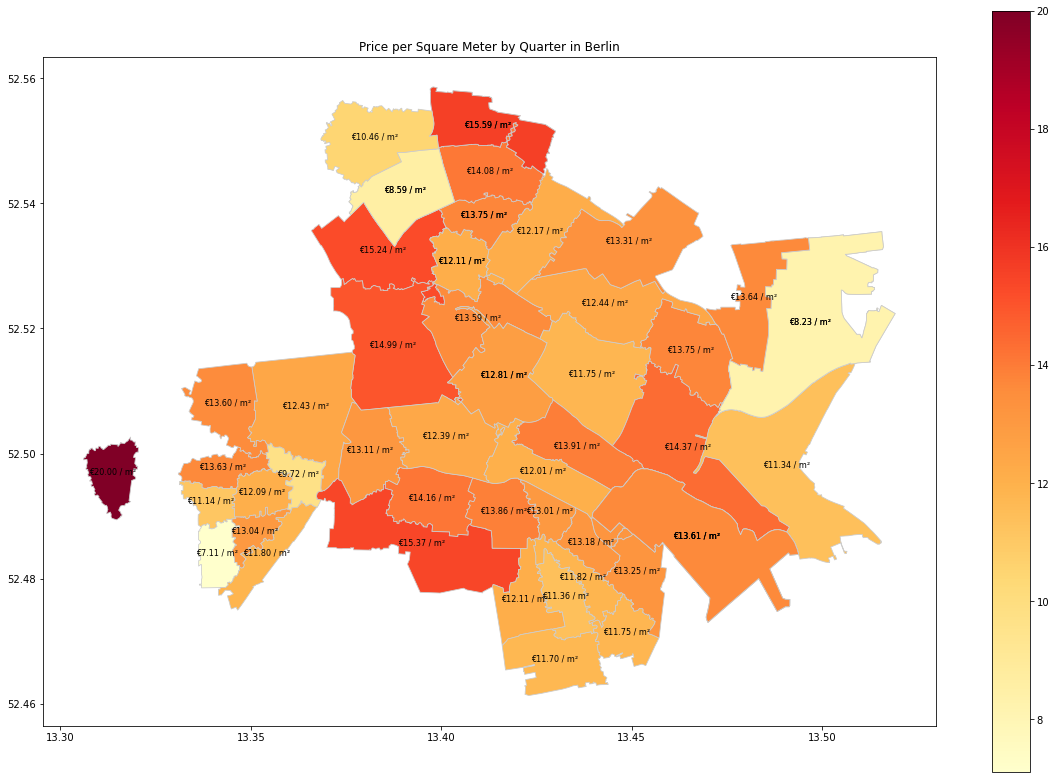

In [26]:
# Plotting the map with the color gradient
fig, ax = plt.subplots(1, 1, figsize=(20, 14))
gdf_berlin.plot(column='price_per_meter', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Annotate each area with the price per square meter in euros, only if the value is not NaN
for _, row in gdf_berlin.iterrows():
    if not np.isnan(row['price_per_meter']):  # Check if price_per_meter is not NaN
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, f"€{row['price_per_meter']:.2f} / m²",
                ha='center', fontsize=8, color="black")

plt.title('Price per Square Meter by Quarter in Berlin')
plt.show()

In [27]:
df = pd.read_csv("./data/historical_prices_berlin.csv")
df

,Year,Apartment (1 bedroom) in City Centre,% Change,Price Per m2 (35m2),Price Per m2 (50m2),Price Per m2 (42.5m2)
0,2010,€530.00,NaN,€15.14,€10.60,€12.87
1,2011,€600.00,13.21%,€17.14,€12.00,€14.57
2,2012,€600.00,0.00%,€17.14,€12.00,€14.57
3,2013,€599.00,-0.17%,€17.11,€11.98,€14.55
4,2014,€648.85,8.34%,€18.54,€12.98,€15.76
5,2015,€684.11,5.42%,€19.55,€13.68,€16.61
6,2016,€704.96,3.05%,€20.14,€14.10,€17.12
7,2017,€778.59,10.47%,€22.25,€15.57,€18.91
8,2018,€861.52,10.69%,€24.61,€17.23,€20.92
9,2019,€905.53,5.09%,€25.87,€18.11,€21.99


In [28]:
# Prepare data
X = df['Year'].values.reshape(-1, 1)
y = df['Price Per m2 (42.5m2)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Model Evaluation:
Mean Absolute Error (MAE): 1.36
Root Mean Square Error (RMSE): 1.51


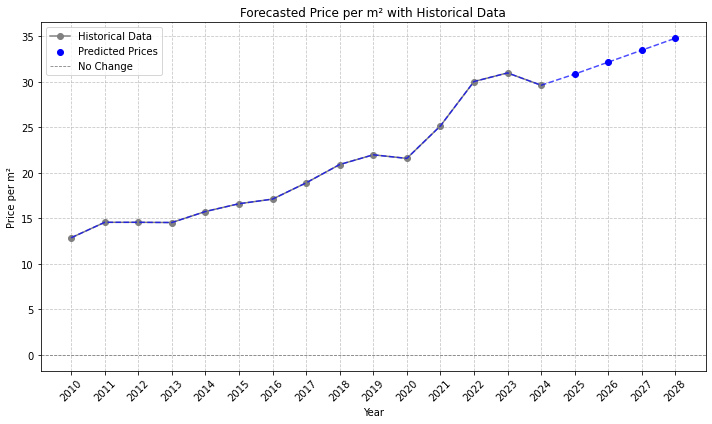

Exact Predicted Prices per m²:
Year 2025: €30.86
Year 2026: €32.18
Year 2027: €33.49
Year 2028: €34.80


In [29]:
# Fit a linear regression model
model = LinearRegression()

# Reshape 'Year' into a 2D array for the model
X = df['Year'].values.reshape(-1, 1)
y = df['Price Per m2 (42.5m2)']

# Fit the model
model.fit(X, y)

# Generate future years for prediction
future_years = np.array([2025, 2026, 2027, 2028]).reshape(-1, 1)

# Predict prices per m² for future years
predictions = model.predict(future_years)

# Combine data for smoother visualization
forecast_years = np.append(df['Year'], future_years.flatten())
forecast_prices = np.append(df['Price Per m2 (42.5m2)'], predictions)

# Plot the historical data and predictions
plt.figure(figsize=(10, 6))

# Line plot for historical data with scatter points
plt.plot(df['Year'], df['Price Per m2 (42.5m2)'], color='gray', label='Historical Data', marker='o', linestyle='-', markersize=6)

# Scatter points for future predictions
plt.scatter(future_years.flatten(), predictions, color='blue', label='Predicted Prices', zorder=5)

# Smooth line connecting historical and future data
plt.plot(forecast_years, forecast_prices, '--', color='blue', alpha=0.7)

# Formatting
plt.xticks(forecast_years, labels=[str(year) for year in forecast_years], rotation=45)
plt.title('Forecasted Price per m² with Historical Data')
plt.xlabel('Year')
plt.ylabel('Price per m²')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='No Change')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Output the exact predicted prices for the future years
predicted_prices = dict(zip(future_years.flatten(), predictions))
print("Exact Predicted Prices per m²:")
for year, price in predicted_prices.items():
    print(f"Year {year}: €{price:.2f}")


### Prediction range
Incorporating MAE into the predictions to provide a range alongside the estimated values

Mean Absolute Error (MAE): 1.41


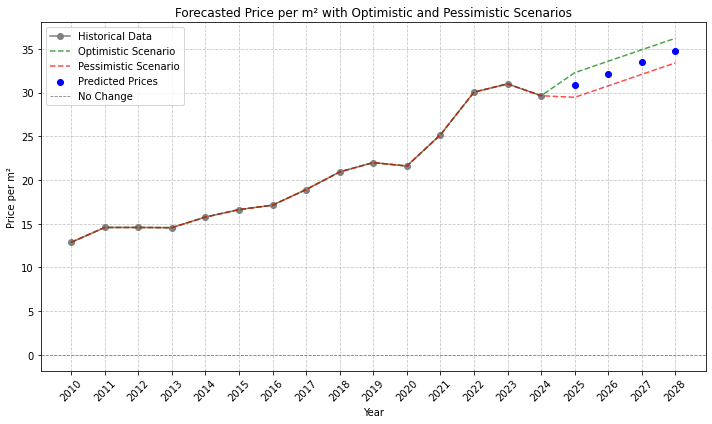

Predicted Prices per m² with Scenarios:
Year 2025: Predicted = €30.86, Optimistic = €32.27, Pessimistic = €29.46
Year 2026: Predicted = €32.18, Optimistic = €33.59, Pessimistic = €30.77
Year 2027: Predicted = €33.49, Optimistic = €34.90, Pessimistic = €32.08
Year 2028: Predicted = €34.80, Optimistic = €36.21, Pessimistic = €33.40


In [30]:
# Prepare the data
X = df['Year'].values.reshape(-1, 1)
y = df['Price Per m2 (42.5m2)']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict prices on historical data to calculate MAE
y_pred = model.predict(X)
mae = mean_absolute_error(y, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Generate future years for prediction
future_years = [2025, 2026, 2027, 2028]

# Initialize arrays for iterative predictions
forecast_years = list(df['Year'])
forecast_prices = list(df['Price Per m2 (42.5m2)'])
optimistic_prices = list(df['Price Per m2 (42.5m2)'])
pessimistic_prices = list(df['Price Per m2 (42.5m2)'])

# Iteratively predict future values and apply MAE for scenarios
for year in future_years:
    forecast_years.append(year)
    
    # Predict the price for the current year
    current_prediction = model.predict(np.array([[year]]))[0]
    forecast_prices.append(current_prediction)
    
    # Calculate optimistic and pessimistic scenarios using MAE
    optimistic_prices.append(current_prediction + mae)
    pessimistic_prices.append(current_prediction - mae)

# Plot the historical data and predictions
plt.figure(figsize=(10, 6))

# Historical data
plt.plot(df['Year'], df['Price Per m2 (42.5m2)'], color='gray', label='Historical Data', marker='o', linestyle='-', markersize=6)

# Optimistic and pessimistic scenarios
plt.plot(forecast_years, optimistic_prices, '--', color='green', label='Optimistic Scenario', alpha=0.7)
plt.plot(forecast_years, pessimistic_prices, '--', color='red', label='Pessimistic Scenario', alpha=0.7)

# Future predictions
plt.scatter(future_years, forecast_prices[-len(future_years):], color='blue', label='Predicted Prices', zorder=5)

# Formatting
plt.xticks(forecast_years, labels=[str(year) for year in forecast_years], rotation=45)
plt.title('Forecasted Price per m² with Optimistic and Pessimistic Scenarios')
plt.xlabel('Year')
plt.ylabel('Price per m²')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='No Change')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Output the exact predicted prices for future years
print("Predicted Prices per m² with Scenarios:")
for year, price, opt, pess in zip(future_years, forecast_prices[-len(future_years):], optimistic_prices[-len(future_years):], pessimistic_prices[-len(future_years):]):
    print(f"Year {year}: Predicted = €{price:.2f}, Optimistic = €{opt:.2f}, Pessimistic = €{pess:.2f}")